In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [64]:
f_c = 5
f_s = 10
fading_std = 0.6
fading_const = 0.5
fading_mean = 0

In [3]:
factor = 8
def QPSK(message,f_c,f_s,flag):
  sym_p = 2 # symbol period
  t = np.linspace(0,1,factor*f_s) # for one symbol period
  fin_sig = np.array([])
  plt.figure(figsize=(100,40))
  for ch in message:
    arr = np.unpackbits(np.array(ord(ch),dtype=np.uint8))
    for i in range(0,8,2):
      b1 = arr[i]
      b2 = arr[i+1]
      fin_sig = np.append(fin_sig,((-1)**b1)*np.cos(2*np.pi*f_c*t) + ((-1)**b2)*np.sin(2*np.pi*f_c*t) )
  if flag:
    plt.plot(fin_sig)
  return fin_sig

In [13]:
from scipy.signal import butter,lfilter
def design_lpf(fs, wc, order):
    # Normalize the cutoff frequency
    wn = wc #/ (0.5 * fs)

    # Design the filter using Butterworth filter design
    b, a = butter(order, wn, btype='low')

    return b, a

def QPSK_demod(message,f_osc,f_s):
  one_sym_len = factor*f_s    # length of one symbol
  tot_sym = int(len(message)/(one_sym_len))   # Total number of symbols in the message
  t = np.linspace(0,1,one_sym_len)

  b,a = design_lpf(f_s,f_osc/one_sym_len,2)

  # temp = np.cos(2*np.pi*f_osc*t) * message

  # plt.subplot(3,1,1)
  # plt.plot(abs(fft(message)))
  # plt.subplot(3,1,2)
  # plt.plot(abs(fft(temp)))
  # plt.subplot(3,1,3)
  # plt.plot(abs(fft(lfilter(b,a,temp))))
  lst = []
  for i in range(0,tot_sym):
    b1 = lfilter(b,a,np.cos(2*np.pi*f_osc*t) * message[i*one_sym_len:(i+1)*one_sym_len])
    b2 = lfilter(b,a,np.sin(2*np.pi*f_osc*t) * message[i*one_sym_len:(i+1)*one_sym_len])

    if b1[int(one_sym_len/2)] > 0 :
      lst.append(0)
    else:
      lst.append(1)

    if b2[int(one_sym_len/2)] > 0:
      lst.append(0)
    else:
      lst.append(1)



  # plt.subplot(2,1,1)
  # plt.plot(b1)
  # plt.subplot(2,1,2)
  # plt.plot(b2)
  answer = ""
  for i in range(0,len(lst),8):
    curr = lst[i:i+8]
    val = 128
    temp_ans = 0
    for j in curr:
      temp_ans += (val*j)
      val/=2
    answer+=chr(int(temp_ans))

  return lst,answer


In [22]:
# Bit Error Analysis

def BER(og,rec,flag):
  err=0
  for i in range(0,len(og)):
    if og[i]!=rec[i]:
      err+=1
  if flag:
    print("Total Bits : "+ str(len(og)))
    print("Error Bits : "+ str(err))
    print("Bit Error Rate : "+ str(err/len(og)))
  return err/len(og)


In [5]:
from numpy.ma.core import sqrt
def AWGN(signal, snr, plot):
  signal_power = sum(signal**2)/len(signal)
  noise_power = (signal_power)*(10**(-snr/10))

  mean = 0
  std = sqrt(noise_power)  # Noise Power = Variance

  noise = np.random.normal(mean,std,len(signal))
  if plot:
    plt.plot(noise)

  return signal + noise


In [107]:
#Multipath

def Multipath(signal,snr,num_paths):
  signal_power = sum(signal**2)/len(signal)
  noise_power = (signal_power)*(10**(-snr/10))

  delay = np.random.poisson(lam = 10, size = num_paths)

  h = np.sqrt(fading_const)*(np.random.normal(fading_mean,fading_std,num_paths) + 1j*(np.random.normal(fading_mean,fading_std,num_paths)))
  #h = 0.5+1j*0.5
  fin_sig = np.zeros(len(signal)).astype('complex128')
  #plt.figure(figsize = (20,10))
  for i in range(0,num_paths):
    #plt.subplot(num_paths+1,2,i+1)
    val = h[i]*(np.append(np.zeros(delay[i]),signal[:-delay[i]]))
    #plt.plot(abs(val))
    fin_sig += val
  #plt.subplot(num_paths+1,2,num_paths+1)
  #plt.plot(abs(fin_sig))

  return fin_sig + AWGN(signal,snr,False)


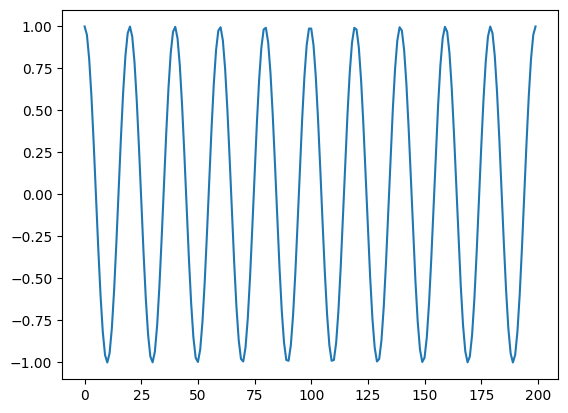

In [ ]:
t_max = 1
f_samp = 200
f_c = 10

t = np.linspace(0,t_max,t_max*f_samp)

signal = np.cos(2*np.pi*f_c*t)
plt.plot(signal)

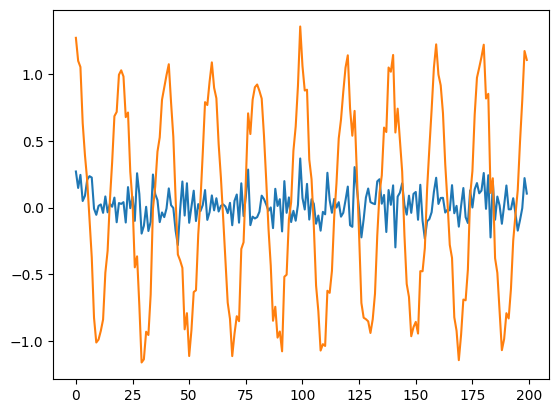

In [ ]:
plt.plot(AWGN(signal,15,True))

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


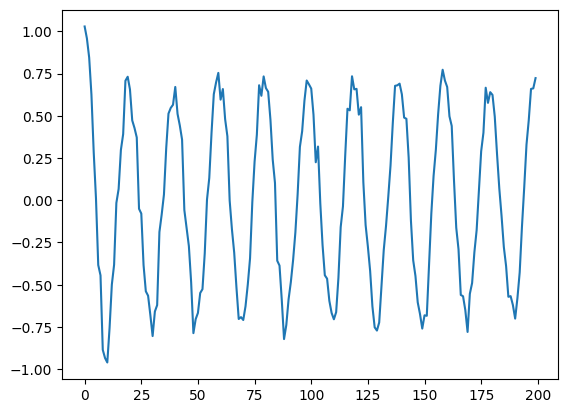

In [ ]:
plt.plot(Multipath(signal,20,10))

In [7]:
message = 'Hello, My name is Prafful and I Study in NIT Hamirpur, Himachal Pradesh'
mod_message = QPSK(message,5,10,False)
received = Multipath(mod_message,1,10)

<Figure size 10000x4000 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


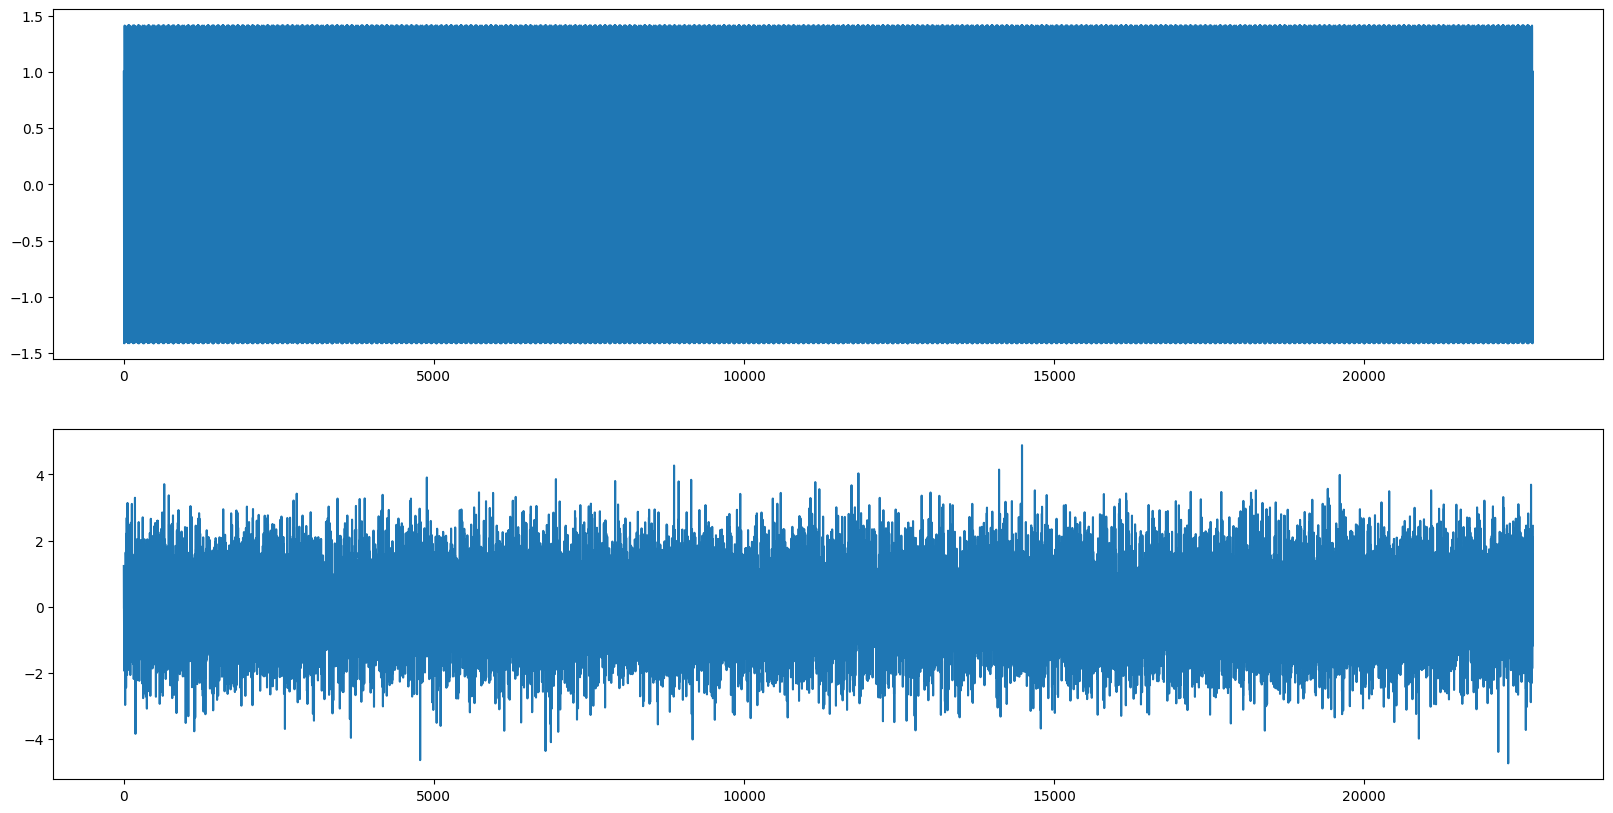

In [8]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(mod_message)
plt.subplot(2,1,2)
plt.plot(received)

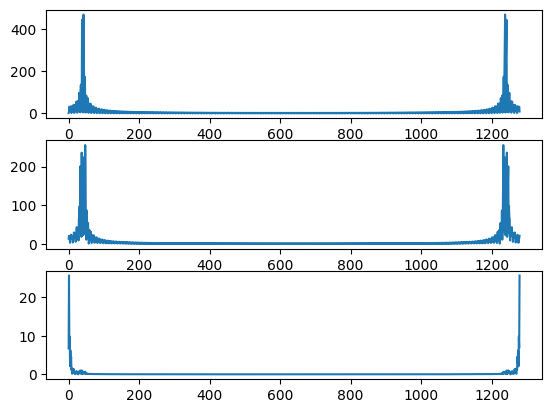

In [ ]:
QPSK_demod(mod_message,5,10)

In [55]:
og_bits, og_message = QPSK_demod(mod_message,5,10)
og_message

'Hello, My name is Prafful and I Study in NIT Hamirpur, Himachal Pradesh'

In [56]:
rec_bits,rec_message = QPSK_demod(received,5,10)
rec_message

'@ehlo, My namÍ is$prafful!ajd!I Wtwäi`in$^AT Hamirpeòl HÉmafhgl Pradesi'

In [57]:
  print(og_bits)
  print(rec_bits)

[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 

In [58]:
BER(og_bits,rec_bits,True)

Total Bits : 568
Error Bits : 28
Bit Error Rate : 0.04929577464788732


0.04929577464788732

In [97]:
# BER Performance for varying SNR , No Multipath
def BER_FOR_SNR():
  message_t = "Hello, My Name is Prafful and i study in National Institute of Technology, Hamirpur, ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt"
  mod_message_t = QPSK(message_t,f_c,f_s,False)
  num_paths = 10
  og_bits_t, og_message_t = QPSK_demod(mod_message_t,f_c,f_s)
  ber_lst = []
  for i in range(-60,20,1):
    snr = i
    received_t = AWGN(mod_message_t,snr,False)
    rec_bits_t, rec_message_t = QPSK_demod(received_t,f_c,f_s)
    ber_lst.append(BER(og_bits_t,rec_bits_t,False)*100)
  plt.plot(range(-60,20,1),ber_lst)

In [101]:
# BER Performance for varying SNR , No Multipath
def BER_FOR_NumPaths():
  message_t = "Hello, My Name is Prafful and i study in National Institute of Technology, Hamirpur, ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt"
  mod_message_t = QPSK(message_t,f_c,f_s,False)
  snr = 10
  og_bits_t, og_message_t = QPSK_demod(mod_message_t,f_c,f_s)
  ber_lst = []
  for i in range(1,60,1):
    num_paths = i
    received_t = Multipath(mod_message_t,snr,num_paths)
    rec_bits_t, rec_message_t = QPSK_demod(received_t,f_c,f_s)
    ber_lst.append(BER(og_bits_t,rec_bits_t,False)*100)
  plt.plot(range(1,60,1),ber_lst)

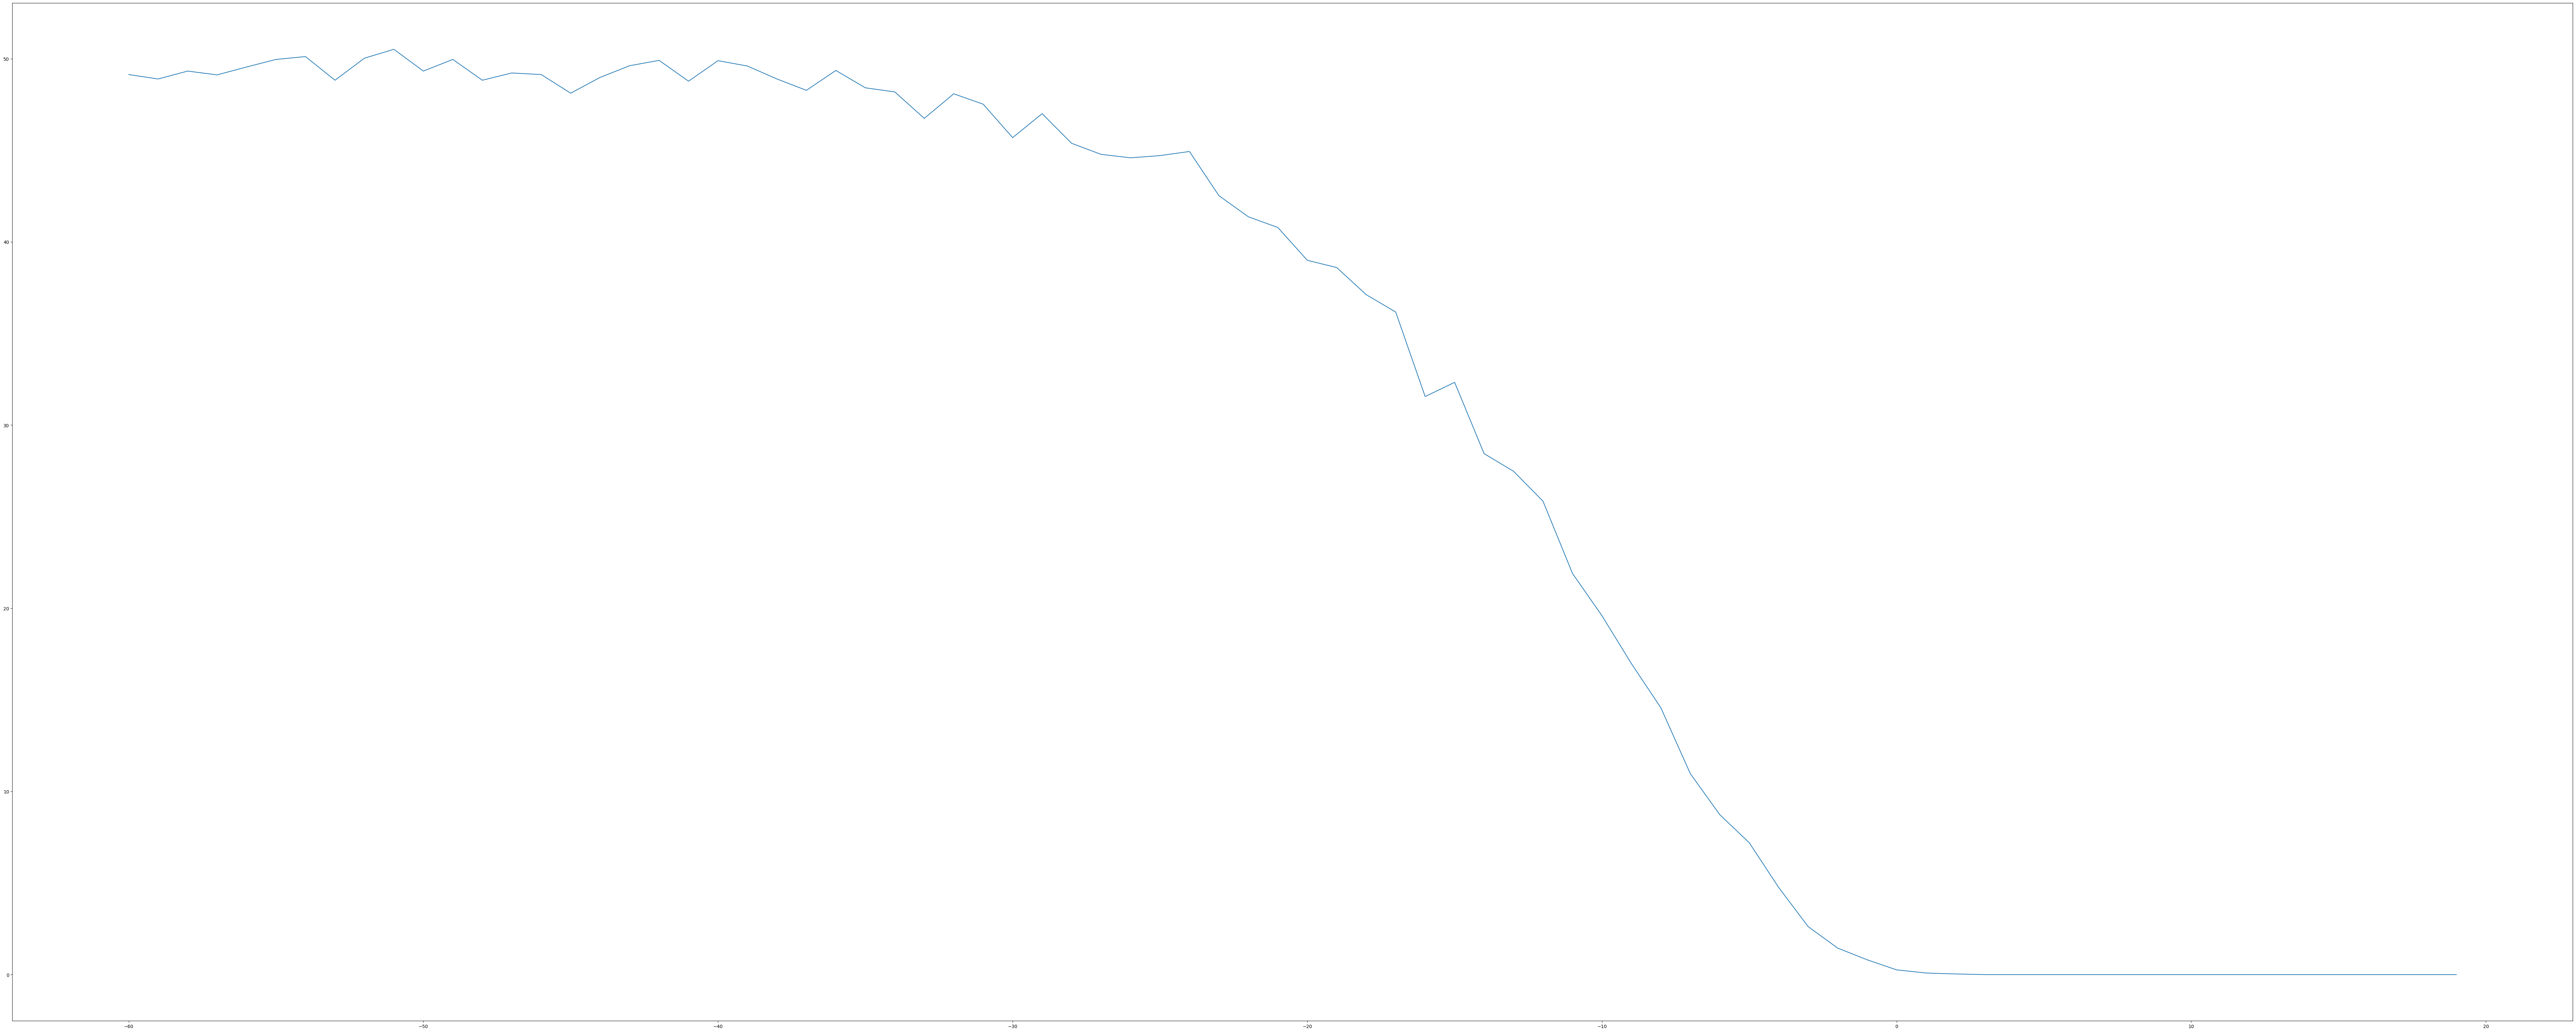

In [98]:
BER_FOR_SNR()

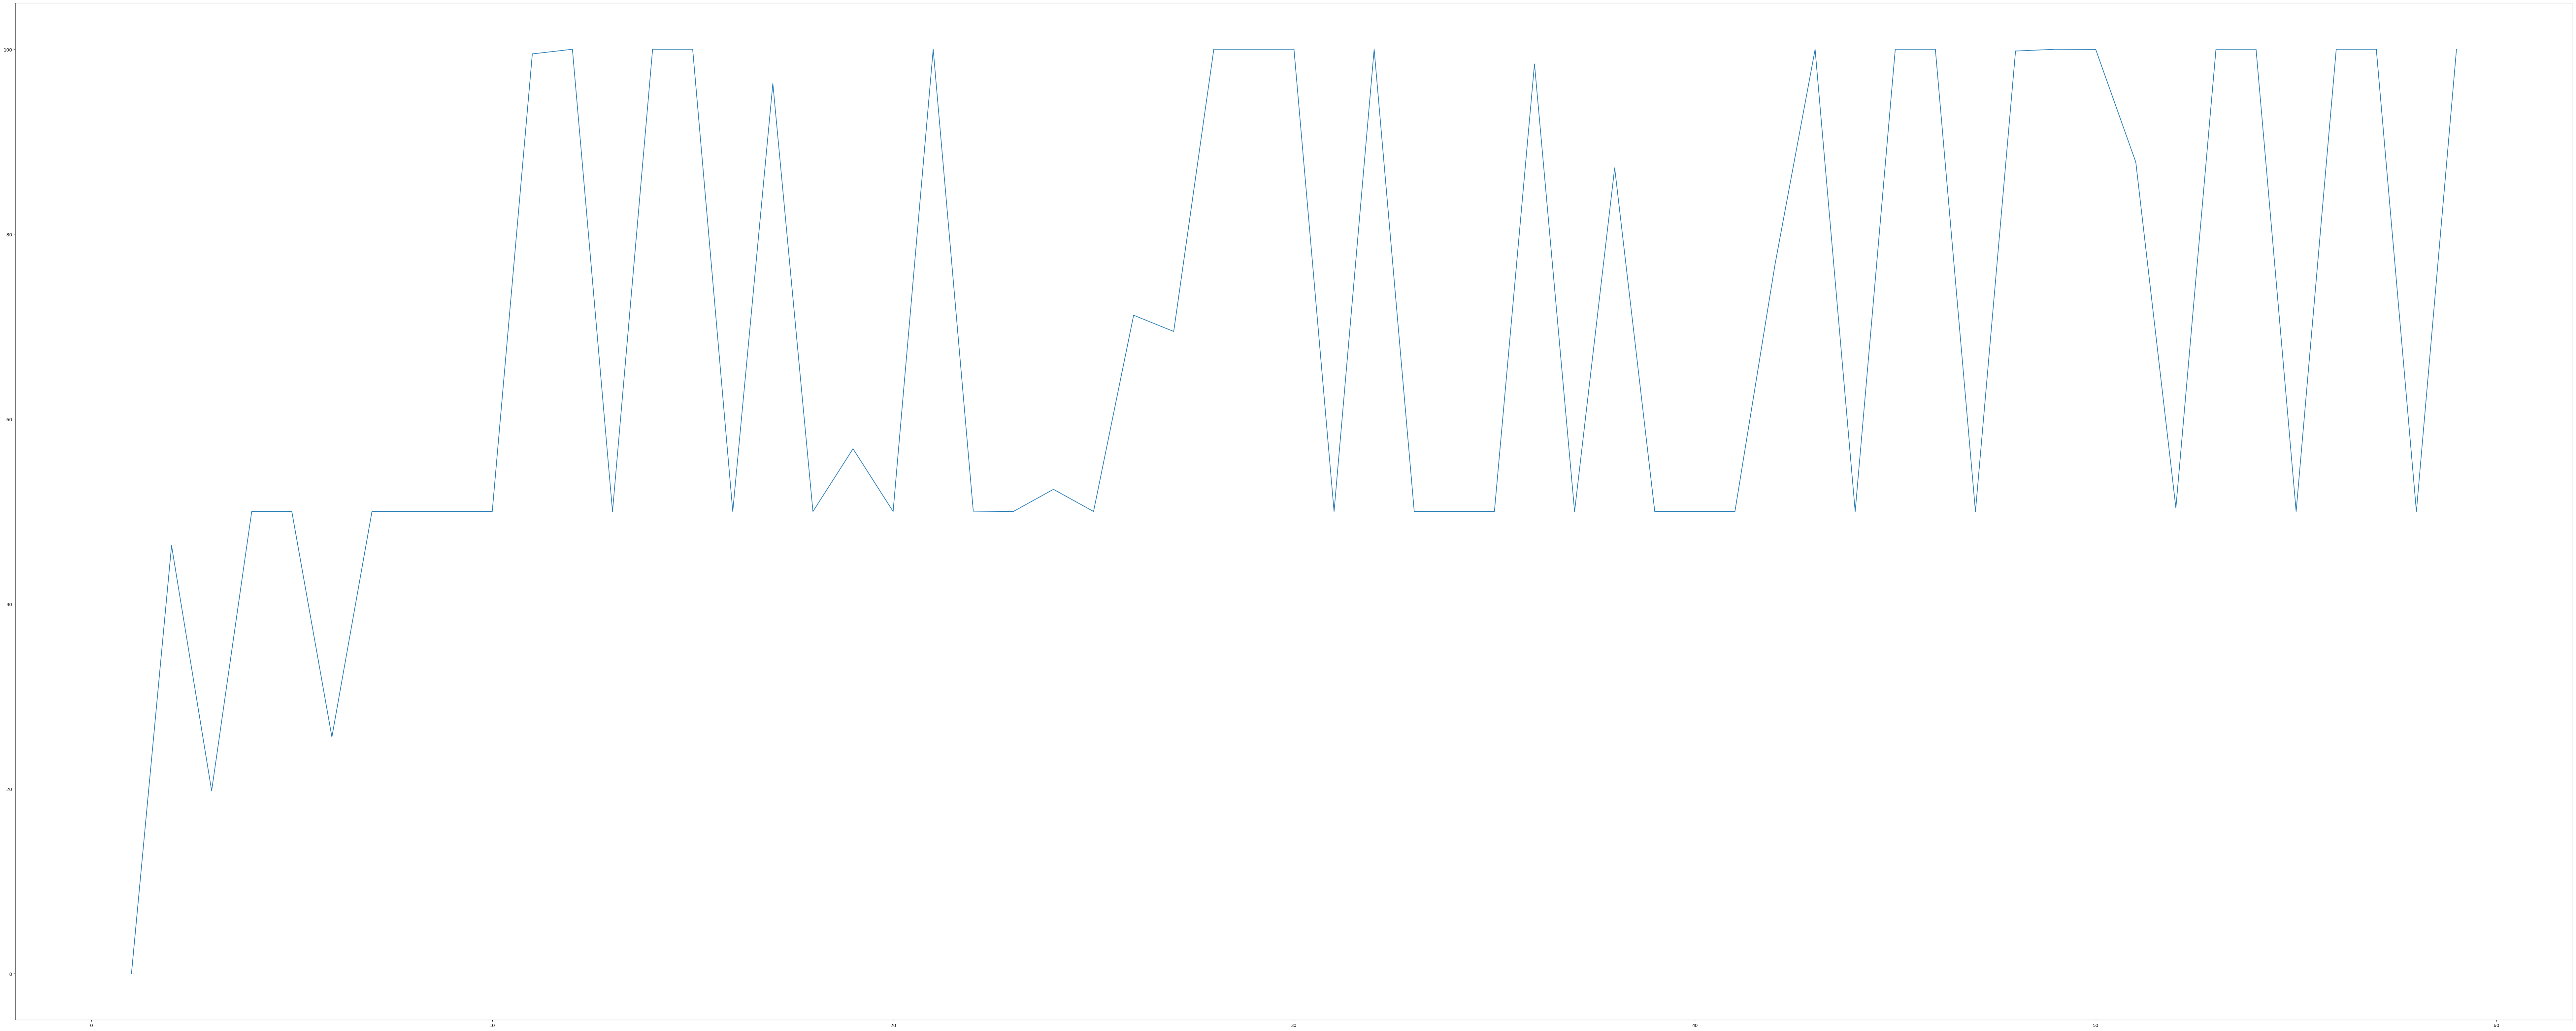

In [106]:
BER_FOR_NumPaths()